In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Conv2D, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from functools import reduce
%matplotlib inline

Using TensorFlow backend.


In [2]:
labels = pd.read_csv('./processed_data/20150101-20170830-gen_per_prod_type.csv', parse_dates=True, index_col=0)
labels.drop_duplicates(keep='last', inplace=True)
labels = labels.resample('1H').mean()
labels = labels.shift(-1)
labels = labels['2015']

In [3]:
labels.head()

,biomass,brown_coal,hard_coal,wind_offshore,pumped_hydro,solar,river_hydro,wind_onshore,nuclear,other
MTU,,,,,,,,,,
2015-01-01 00:00:00,4261.00,15364.75,1929.75,516.25,409.50,0.0,2617.00,8367.5,11086.25,4743.50
2015-01-01 01:00:00,4295.50,14852.75,1824.00,514.00,632.75,0.0,2578.75,8604.0,11026.25,4836.50
2015-01-01 02:00:00,4313.75,14111.00,1959.00,517.75,558.25,0.0,2545.25,8617.0,11027.75,4840.25
2015-01-01 03:00:00,4308.50,14149.00,2012.25,519.75,602.75,0.0,2557.75,8707.5,10962.25,4820.75
2015-01-01 04:00:00,4304.00,13509.50,1753.50,520.00,629.25,0.0,2554.75,8775.5,10696.00,4958.00


In [4]:
labels = labels.solar.to_frame()

In [5]:
len(labels)

8760

In [6]:
def prepare_training_data(months=range(1, 13, 1), inputs=['SWDIFDS_RAD', 'SWDIRS_RAD'], return_index=True, 
                         base_path='./processed_data/weather', scale=True):
    
    indices = {}
    tensors = {}
    
    for variable in inputs:
        
        index_arr = []
        data_arr = []
        amax = 0

        for month in months:
            
            date = dt.date(2015, month, 1).strftime('%Y%m')
            filename = os.path.join(base_path, '{}.2D.{}'.format(variable, date))
            
            index_arr.append(pd.read_csv('{}.txt'.format(filename), parse_dates=True, header=None, index_col=0))
            
            data = np.load('{}.npy'.format(filename))
            
            max_val = np.amax(data)
            
            if scale:
                amax = max(amax, max_val)
            
            data_arr.append(data)
        
        if scale:
            data_arr /= amax

        indices[variable] = pd.concat(index_arr).index
        tensors[variable] = np.vstack(data_arr)

    if return_index:
        return indices, tensors
    else:
        return tensors

In [7]:
def check_indices(indices):
    
    missing = dict([(key, None) for key in indices.keys()])
    
    common_index = reduce(lambda  left,right: left.join(right, how='outer'), indices.values())
    
    for key, val in indices.items():
        missing[key] = common_index.difference(val)
        
    return missing

In [8]:
VARS = ['SWDIFDS_RAD', 'SWDIRS_RAD', 'TOT_PRECIP']

In [9]:
indices, tensors = prepare_training_data(range(1, 13, 1), VARS)

In [10]:
check_indices(indices)

{'SWDIFDS_RAD': DatetimeIndex(['2016-01-01 02:00:00'], dtype='datetime64[ns]', name=0, freq=None),
 'SWDIRS_RAD': DatetimeIndex(['2016-01-01 02:00:00'], dtype='datetime64[ns]', name=0, freq=None),
 'TOT_PRECIP': DatetimeIndex(['2015-01-01 01:00:00', '2015-01-01 04:00:00',
                '2015-01-01 05:00:00', '2015-01-01 07:00:00',
                '2015-01-01 10:00:00', '2015-01-01 11:00:00',
                '2015-01-01 13:00:00', '2015-01-01 16:00:00',
                '2015-01-01 17:00:00', '2015-01-01 19:00:00',
                ...
                '2015-12-30 19:00:00', '2015-12-30 23:00:00',
                '2015-12-31 01:00:00', '2015-12-31 05:00:00',
                '2015-12-31 07:00:00', '2015-12-31 11:00:00',
                '2015-12-31 13:00:00', '2015-12-31 17:00:00',
                '2015-12-31 19:00:00', '2015-12-31 23:00:00'],
               dtype='datetime64[ns]', name=0, length=3888, freq=None)}

In [11]:
for t in tensors.values():
    print(t.shape)

(8760, 145, 110)
(8760, 145, 110)
(8760, 145, 110)


In [12]:
index = indices[next(iter(indices))]

In [13]:
mask = labels.solar.isnull().values
labels.dropna(inplace=True)

In [14]:
not_missing = np.array([pos for pos, _ in enumerate(~mask) if _ ])

In [15]:
len(not_missing)

8735

In [16]:
scaler = MinMaxScaler()
labels = scaler.fit_transform(labels)

In [17]:
stacked_features = np.stack((tensors[var] for var in VARS), axis=-1)

In [18]:
stacked_features = stacked_features[not_missing]

In [19]:
stacked_features.shape

(8735, 145, 110, 3)

In [20]:
labels.shape

(8735, 1)

In [21]:
def daily_train_valid_test_split(X, y, index, ret_test_index=True, test_size=.15, valid_size=.15, random_state=7):
    
    assert len(X) == len(y) == len(index), 'Input dimensions not matching'
    
    len_test = int(len(X) // (1 / test_size) // 24)
    len_valid = int(len(X) // (1 / valid_size) // 24)
        
    available_days = index.map(lambda t: t.date()).unique()
    
    rnd = np.random.RandomState(random_state)
    indices = rnd.choice(available_days, size=len_test+len_valid)
        
    ix_test = [i for i, date in enumerate(index.date) if date in indices[:len_test]]
    ix_valid = [i for i, date in enumerate(index.date) if date in indices[len_test:]]
    ix_train = [i for i, date in enumerate(index.date) if not date in indices]
    
    X_train = X[ix_train]
    y_train = y[ix_train]
    X_test = X[ix_test]
    y_test = y[ix_test]
    X_valid = X[ix_valid]
    y_valid = y[ix_valid]
    
    if ret_test_index:
        return X_train, X_valid, X_test, y_train, y_valid, y_test, indices[ix_test]
    else:
        return X_train, X_valid, X_test, y_train, y_valid, y_test

In [22]:
X_train, X_valid, X_test, y_train, y_valid, y_test = daily_train_valid_test_split(stacked_features, labels,
                                                                                  index[not_missing],
                                                                                  ret_test_index=False)

In [23]:
samples, w, h, channels = (stacked_features.shape[i] for i in range(4))
# X_train, X_test, y_train, y_test = train_test_split(stacked_features, labels, test_size=0.2, random_state=7)

In [24]:
input_layer = Input(shape=(w, h, channels))
x = Conv2D(20, activation='relu', kernel_size=(8, 8), strides=(8, 8), padding='same')(input_layer)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='relu')(x)
model = Model(inputs=input_layer, outputs=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 145, 110, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 14, 20)        3860      
_________________________________________________________________
flatten_1 (Flatten)          (None, 5320)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                340544    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 344,469
Trainable params: 344,469
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [26]:
checkpoint = ModelCheckpoint('./models/renewable_pred_solar.hdf5', save_best_only=True)
hist = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[checkpoint])

Train on 6480 samples, validate on 1224 samples
Epoch 1/10
6480/6480 [==============================] - 5s - loss: 0.0102 - mean_absolute_error: 0.0592 - val_loss: 0.0077 - val_mean_absolute_error: 0.0503
Epoch 2/10
6480/6480 [==============================] - 2s - loss: 0.0068 - mean_absolute_error: 0.0467 - val_loss: 0.0063 - val_mean_absolute_error: 0.0447
Epoch 3/10
6480/6480 [==============================] - 2s - loss: 0.0053 - mean_absolute_error: 0.0407 - val_loss: 0.0058 - val_mean_absolute_error: 0.0435
Epoch 4/10
6480/6480 [==============================] - 2s - loss: 0.0042 - mean_absolute_error: 0.0362 - val_loss: 0.0046 - val_mean_absolute_error: 0.0384
Epoch 5/10
6480/6480 [==============================] - 2s - loss: 0.0035 - mean_absolute_error: 0.0327 - val_loss: 0.0050 - val_mean_absolute_error: 0.0397
Epoch 6/10
6480/6480 [==============================] - 2s - loss: 0.0028 - mean_absolute_error: 0.0291 - val_loss: 0.0056 - val_mean_absolute_error: 0.0411
Epoch 7/10

In [27]:
model = load_model('./models/renewable_pred_solar.hdf5')
pred = model.predict(X_test)

In [28]:
df = pd.DataFrame({'pred':pred.flatten(), 'true':y_test.flatten()})

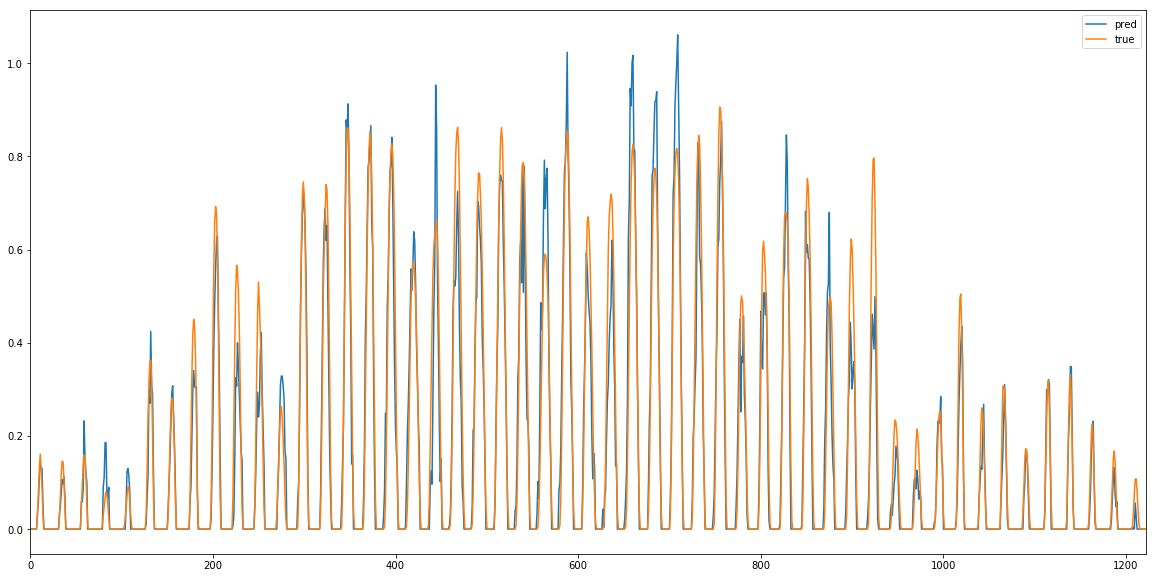

In [29]:
df.plot(figsize=(20,10))

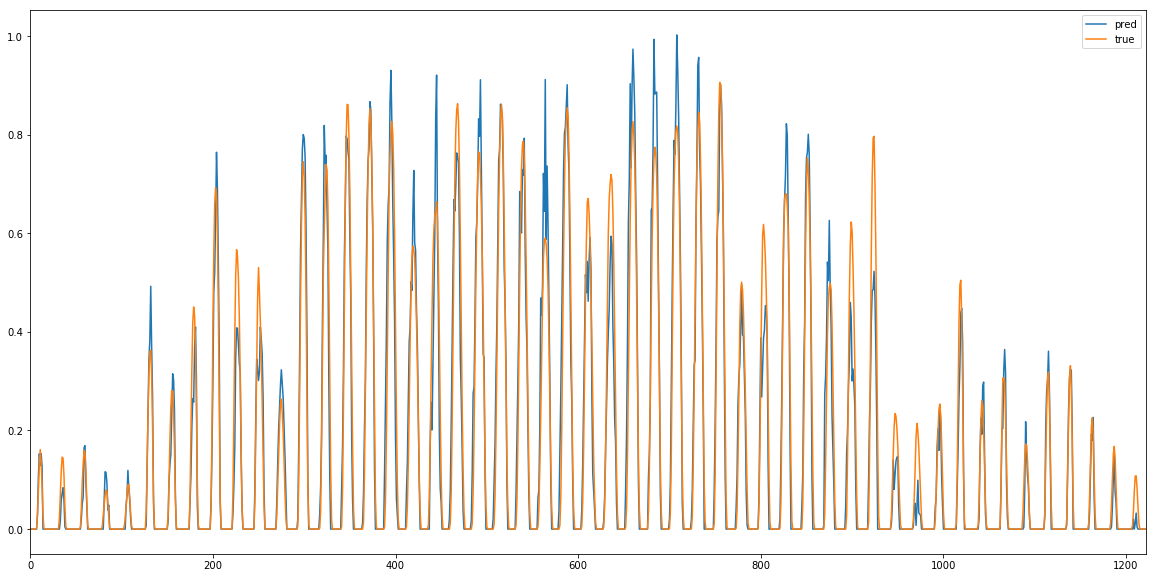

In [195]:
df.plot(figsize=(20,10))

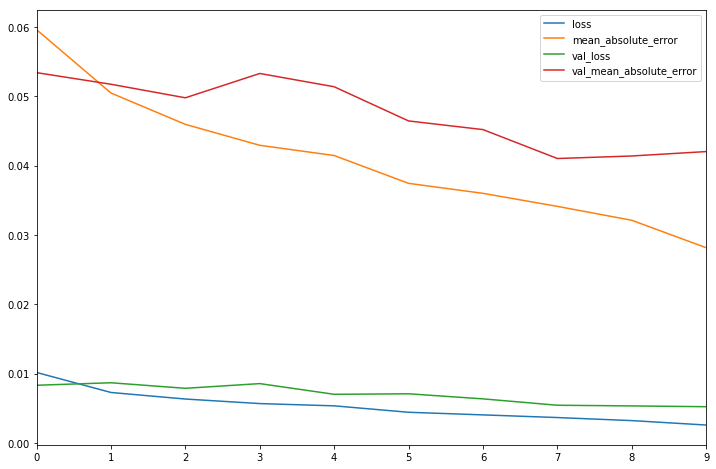

In [153]:
pd.DataFrame(hist.history).plot(figsize=(12, 8))